In [2]:
# --- 0. Install Libraries (and fix potential NumPy 2.0 issues) ---
# Downgrading NumPy to avoid errors with TensorFlow/OpenCV in some environments
!pip install numpy==1.26.4
!pip install tensorflow keras matplotlib opencv-python

# --- IMPORTANT ---
# After these installs finish, you MUST restart your kernel/runtime.
# In Jupyter/VS Code: Kernel -> Restart
# In Google Colab: Runtime -> Restart runtime
# Then, re-run this entire cell.
# -----------------



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 # For loading the prediction image

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)



TensorFlow version: 2.19.0
Keras version: 3.10.0


In [23]:
# --- 1. Define Settings ---
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 25 # You can increase this for better accuracy if needed

# --- 2. Load the Built-in Dataset (Automatic Download) ---
print("Downloading and preparing 'cats_and_dogs_filtered' dataset...")
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# get_file downloads and extracts the data
dataset_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)


In [24]:
# Find the folder where the images were unzipped
# Sometimes it's directly 'cats_and_dogs_filtered', sometimes it's inside another folder
base_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered')
# If the direct path doesn't exist, try the path inside '_extracted'
if not os.path.exists(base_dir):
     base_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered_extracted', 'cats_and_dogs_filtered')

# Set the paths to the training and validation image folders
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

print("Training images are in:", train_dir)
print("Validation images are in:", validation_dir)



Training images are in: C:\Users\Lenovo\.keras\datasets\cats_and_dogs_filtered_extracted\cats_and_dogs_filtered\train
Validation images are in: C:\Users\Lenovo\.keras\datasets\cats_and_dogs_filtered_extracted\cats_and_dogs_filtered\validation


In [25]:
# --- 3. Prepare the Image Data ---
print("Setting up image loaders (generators)...")
# ImageDataGenerator can do things like resizing and rescaling pixels
# We rescale pixel values from 0-255 to 0-1 because models like smaller numbers
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Tell the generators where to find the images and how to load them
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,            # Folder with training images
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to our set size
    batch_size=BATCH_SIZE,          # Load images in batches
    class_mode='binary'             # It's 'binary' because we have 2 classes (cat/dog)
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,         # Folder with validation images
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)



Setting up image loaders (generators)...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
# --- 4. Build the Neural Network (CNN Model) ---
print("Building the neural network model...")
# We use a 'Sequential' model, meaning layers are stacked one after another
model = keras.Sequential([
    # Input Layer: Tells the model the shape of our images (height, width, color channels)
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Convolutional Layer 1: Finds basic patterns (edges, corners)
    # 32 filters, 3x3 kernel size, 'relu' activation function
    layers.Conv2D(32, (3, 3), activation='relu'),
    # Pooling Layer 1: Shrinks the image size, keeps important info
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2: Finds more complex patterns
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Pooling Layer 2: Shrinks again
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3: Finds even more complex patterns
    layers.Conv2D(128, (3, 3), activation='relu'),
    # Pooling Layer 3: Shrinks again
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer: Converts the 2D image features into a 1D list
    layers.Flatten(),

    # Dense Layer (Fully Connected): Like a standard neural network layer
    layers.Dense(512, activation='relu'), # 512 neurons

    # Output Layer: Final decision layer
    # 1 neuron because it's cat OR dog (binary)
    # 'sigmoid' activation gives a probability between 0 (cat) and 1 (dog)
    layers.Dense(1, activation='sigmoid')
])



Building the neural network model...


Compiling the model (getting it ready for training)...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5054 - loss: 0.9837 - val_accuracy: 0.5000 - val_loss: 0.7300
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 666ms/step - accuracy: 0.5382 - loss: 0.6888 - val_accuracy: 0.6320 - val_loss: 0.6494
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 802ms/step - accuracy: 0.6284 - loss: 0.6430 - val_accuracy: 0.6850 - val_loss: 0.6120
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 833ms/step - accuracy: 0.6972 - loss: 0.5656 - val_accuracy: 0.6720 - val_loss: 0.6138
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - accuracy: 0.7407 - loss: 0.5275 - val_accuracy: 0.7190 - val_loss: 0.5897
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 819ms/step - accuracy: 0.7940 - loss: 0.4354 - val_accuracy: 0.6860 - val_loss: 0.6129
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - accuracy: 0.8365 - loss: 0.3413 - val_accuracy: 0.7120 - val_loss: 0.6504
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9001 - loss: 0

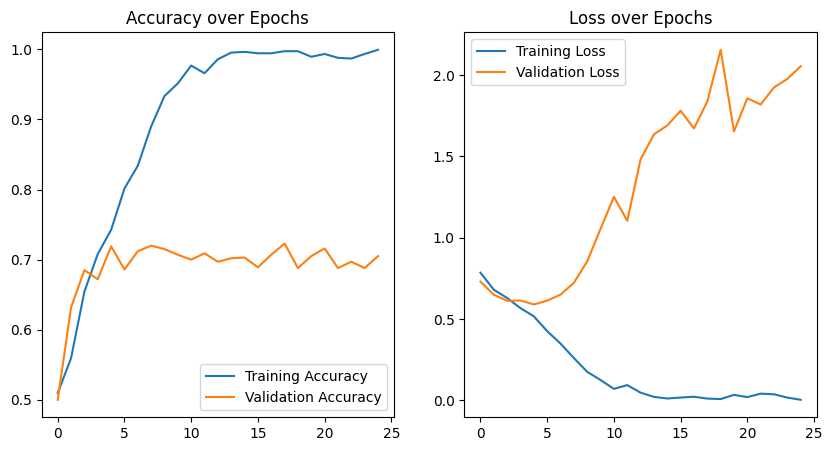

In [27]:
# --- 5. Compile the Model ---
print("Compiling the model (getting it ready for training)...")
model.compile(
    optimizer='adam', # 'adam' is a popular algorithm for updating the model
    loss='binary_crossentropy', # Measures how wrong the predictions are (good for cat/dog)
    metrics=['accuracy'] # We want to track the accuracy during training
)

# Show a summary of the layers in our model
model.summary()

# --- 6. Train the Model ---
print("\nStarting training...")
# 'fit' starts the training process
history = model.fit(
    train_data_gen, # Use the generator for training data
    steps_per_epoch=len(train_data_gen), # How many batches make one full pass (epoch)
    epochs=EPOCHS, # How many full passes over the data
    validation_data=val_data_gen, # Use the generator for validation data
    validation_steps=len(val_data_gen) # How many batches for validation
)
print("Training finished!")

# --- 7. Show Training Results ---
# Get the accuracy and loss values recorded during training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS) # Creates numbers 0, 1, 2... up to EPOCHS-1

# Create a figure to hold the plots
plt.figure(figsize=(10, 5))

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 1) # Position for the first plot (1 row, 2 columns, 1st plot)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend() # Show the labels ('Training Accuracy', 'Validation Accuracy')
plt.title('Accuracy over Epochs')

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2) # Position for the second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

# Display the plots
plt.show()




Making predictions for 1 images...
--- Predicting: IMage 9.jpeg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Result: Likely a dogs (Confidence: 0.97)


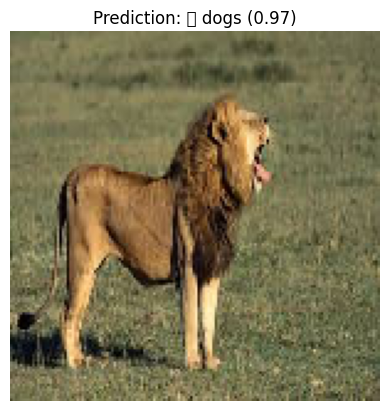

------------------------------


In [29]:
# --- 8. Predict on Multiple Sample Images ---

image_paths_to_predict = [r"C:\Users\Lenovo\Downloads\IMage 9.jpeg"]

# Check if the list has any paths
if image_paths_to_predict:
    print(f"\nMaking predictions for {len(image_paths_to_predict)} images...")

    # Loop through each image path in the list
    for img_path in image_paths_to_predict:
        if os.path.exists(img_path):
            print(f"--- Predicting: {os.path.basename(img_path)} ---") # Show just the file name

            # Load and preprocess the image (same steps as before)
            img = keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = keras.utils.img_to_array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict using the trained model
            prediction = model.predict(img_array)
            score = prediction[0][0]

            # Get the class names like before
            class_names = list(train_data_gen.class_indices.keys())

            # --- Display the image and prediction ---
            plt.figure() # Create a new figure for each image
            plt.imshow(img)
            plt.axis('off')

            if score > 0.5:
                print(f"Result: Likely a {class_names[1]} (Confidence: {score:.2f})")
                plt.title(f"Prediction: 🐶 {class_names[1]} ({score:.2f})")
            else:
                print(f"Result: Likely a {class_names[0]} (Confidence: {1 - score:.2f})")
                plt.title(f"Prediction: 🐱 {class_names[0]} ({1 - score:.2f})")

            plt.show() # Show the plot for this image
            print("-" * 30) # Separator line

        else:
            # If a path in the list is wrong, print a warning
            print(f"\nWarning: Image path not found, skipping: {img_path}")
            print("-" * 30)

else:
    # If the list is empty, print this message
    print("\nSkipping predictions.")
    print("Please add image file paths to the 'image_paths_to_predict' list and re-run section 8.")